# Good practices for analysing MCMC results using `arviz`

Assessing the convergence of a set of MCMC chains is not an easy task in general. `jaxspec` provides a convenient way to analyse the results of a fit using the [`arviz`](https://python.arviz.org/en/stable/) library. This library provides powerful tool to explore Bayesian inference results, such as trace plots, pair plots, and summary statistics. Let's run some MCMCs!

In [1]:
%%capture 
# Hide the output of this cell
import numpyro

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

import numpyro.distributions as dist
from jaxspec.fit import MCMCFitter
from jaxspec.data.util import load_example_obsconf
from jaxspec.model.additive import Blackbodyrad, Powerlaw
from jaxspec.model.multiplicative import Tbabs

spectral_model = Tbabs()*(Powerlaw() + Blackbodyrad())

obsconf = load_example_obsconf("NGC7793_ULX4_PN")

prior = {
    "powerlaw_1_alpha": dist.Uniform(1, 3),
    "powerlaw_1_norm": dist.LogUniform(1e-5, 1e-3),
    "blackbodyrad_1_kT": dist.Uniform(0, 2),
    "blackbodyrad_1_norm": dist.LogUniform(1e-2, 1),
    "tbabs_1_N_H": dist.Uniform(0, 1)
}

fitter = MCMCFitter(spectral_model, prior, obsconf)

In [2]:
result_nuts = fitter.fit(
    num_chains=4, 
    num_warmup=1000, 
    num_samples=1000,
    sampler="nuts",
    mcmc_kwargs={"progress_bar": True}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

From the result object, you can access the `inference_data` attribute, which is an `arviz.InferenceData` object. This leverage the use of every arviz function to analyse the results of the fit.

In [3]:
inference_data = result_nuts.inference_data
inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> prior
	> observed_data

This object carries all the information we need about our fit : the posterior samples, the associated likelihood, posterior predictives and so on. They can be a bit tricky to manipulate at first, as they are based on the [`xarray`](https://docs.xarray.dev/en/stable/), but they provide a lot of flexibility to analyse the results of the fit.

## Trace plot
This visualization is useful to see the evolution of the parameters during the sampling process. It can be used to diagnose convergence issues. The ideal situation is when the chains are well mixed and randomly scattered around the target distribution. If instead, chains are stuck in some region of the parameter space, or show some trends, this might indicate that the sampler did not explore the full parameter space.

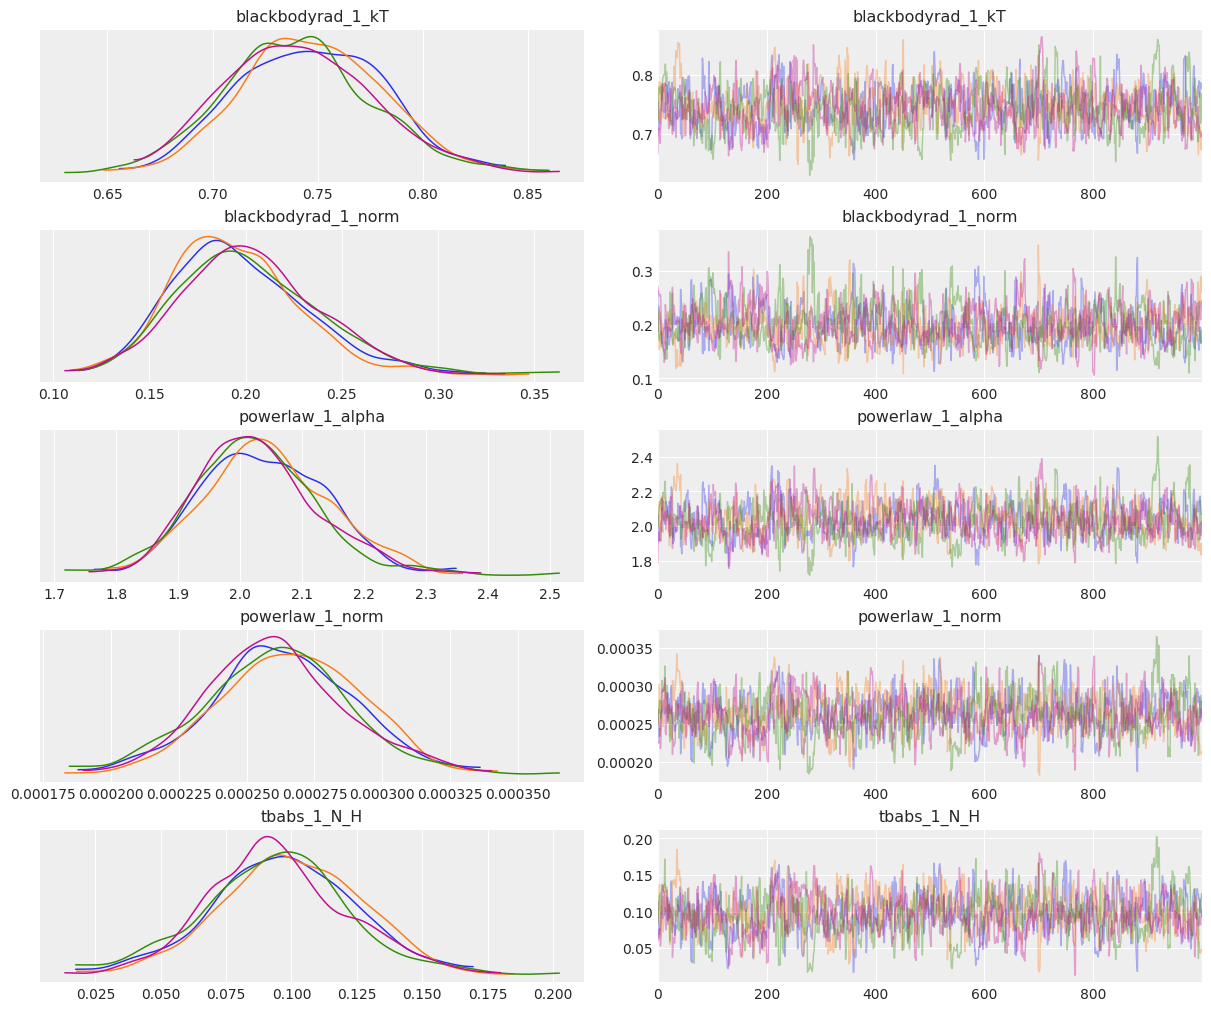

In [4]:
import arviz as az
import matplotlib.pyplot as plt 

with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_trace(inference_data, compact=False)

plt.show()

However, this kind of plot can become messy pretty quickly if you work with numerous chains/walkers, which what you **must do** when using Ensemble Samplers such as ESS or AIES. A general trick proposed by [Vehtari et al. (2019)](https://arxiv.org/abs/1903.08008) is to plot the rank of each sample in the global run instead of its value. This rank should be evenly spread across the steps if the chains are well mixed. This can be done using the `kind="rank_vlines"` argument in the `plot_trace` function.

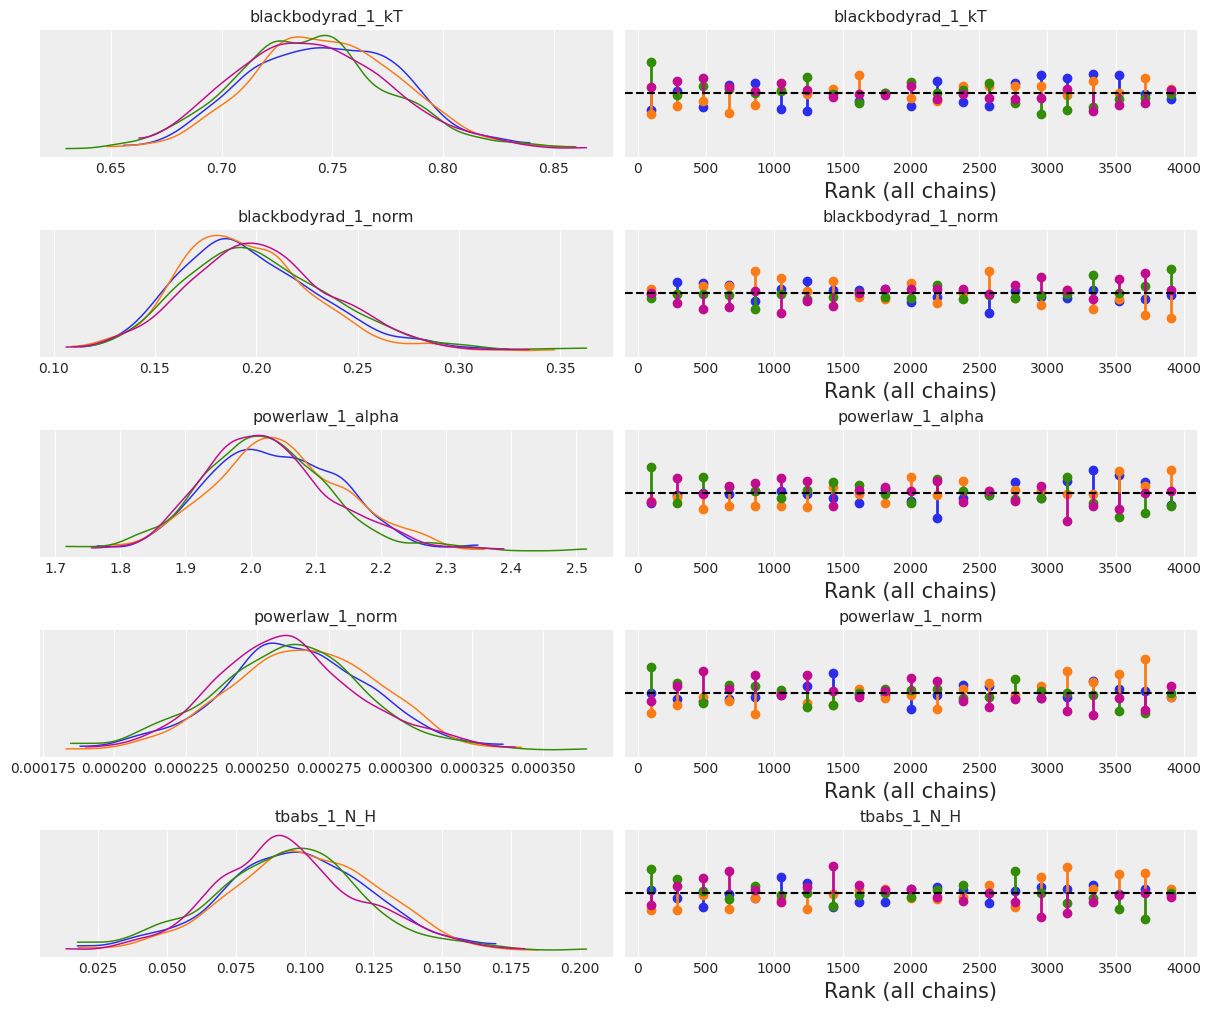

In [5]:
with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_trace(result_nuts.inference_data, compact=False, kind="rank_vlines")

plt.show()

A more quantitative way to assess the convergence of the chains is to use the `summary` function. This function provides a summary of the posterior distribution of the parameters, including the mean, the standard deviation, and the 95% highest posterior density interval.

In [6]:
az.summary(result_nuts.inference_data.posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
blackbodyrad_1_kT,0.744,0.036,0.674,0.807,0.002,0.001,550.0,825.0,1.01
blackbodyrad_1_norm,0.199,0.036,0.132,0.265,0.002,0.001,555.0,935.0,1.01
powerlaw_1_alpha,2.033,0.100,1.849,2.221,0.004,0.003,531.0,880.0,1.01
powerlaw_1_norm,0.000,0.000,0.000,0.000,0.000,0.000,537.0,894.0,1.01
tbabs_1_N_H,0.096,0.027,0.042,0.147,0.001,0.001,522.0,746.0,1.01


The `r_hat` column provides a measure of the splitted Gelman-Rubin statistic with rank normalisartion. The closer this value is to 1, the better. A value larger than 1.01 point to convergence issues. This statistic can be directly computed using the `r_hat` function, [see Vehtari et al. (2019)](https://arxiv.org/abs/1903.08008). The `ess` denotes the Effective Sample Size of the chains, which is a measure of the quality of the samples. The larger the better, in general, we want this value to be larger than 400 for a reliable estimate of the posterior distribution using the NUTS sampler with 1000 warmups and 1000 samples.

In [7]:
rhat = az.rhat(result_nuts.inference_data.posterior)
rhat

<xarray.Dataset> Size: 40B
Dimensions:              ()
Data variables:
    blackbodyrad_1_kT    float64 8B 1.01
    blackbodyrad_1_norm  float64 8B 1.011
    powerlaw_1_alpha     float64 8B 1.012
    powerlaw_1_norm      float64 8B 1.012
    tbabs_1_N_H          float64 8B 1.011

In [8]:
ess = az.ess(result_nuts.inference_data.posterior)
ess

<xarray.Dataset> Size: 40B
Dimensions:              ()
Data variables:
    blackbodyrad_1_kT    float64 8B 549.9
    blackbodyrad_1_norm  float64 8B 554.8
    powerlaw_1_alpha     float64 8B 530.7
    powerlaw_1_norm      float64 8B 536.6
    tbabs_1_N_H          float64 8B 521.8

## Pair plot

This visualization is useful to see the correlation between the parameters. The ideal situation is when the parameters are uncorrelated, which means that the posterior distribution is close to a multivariate Gaussian distribution.

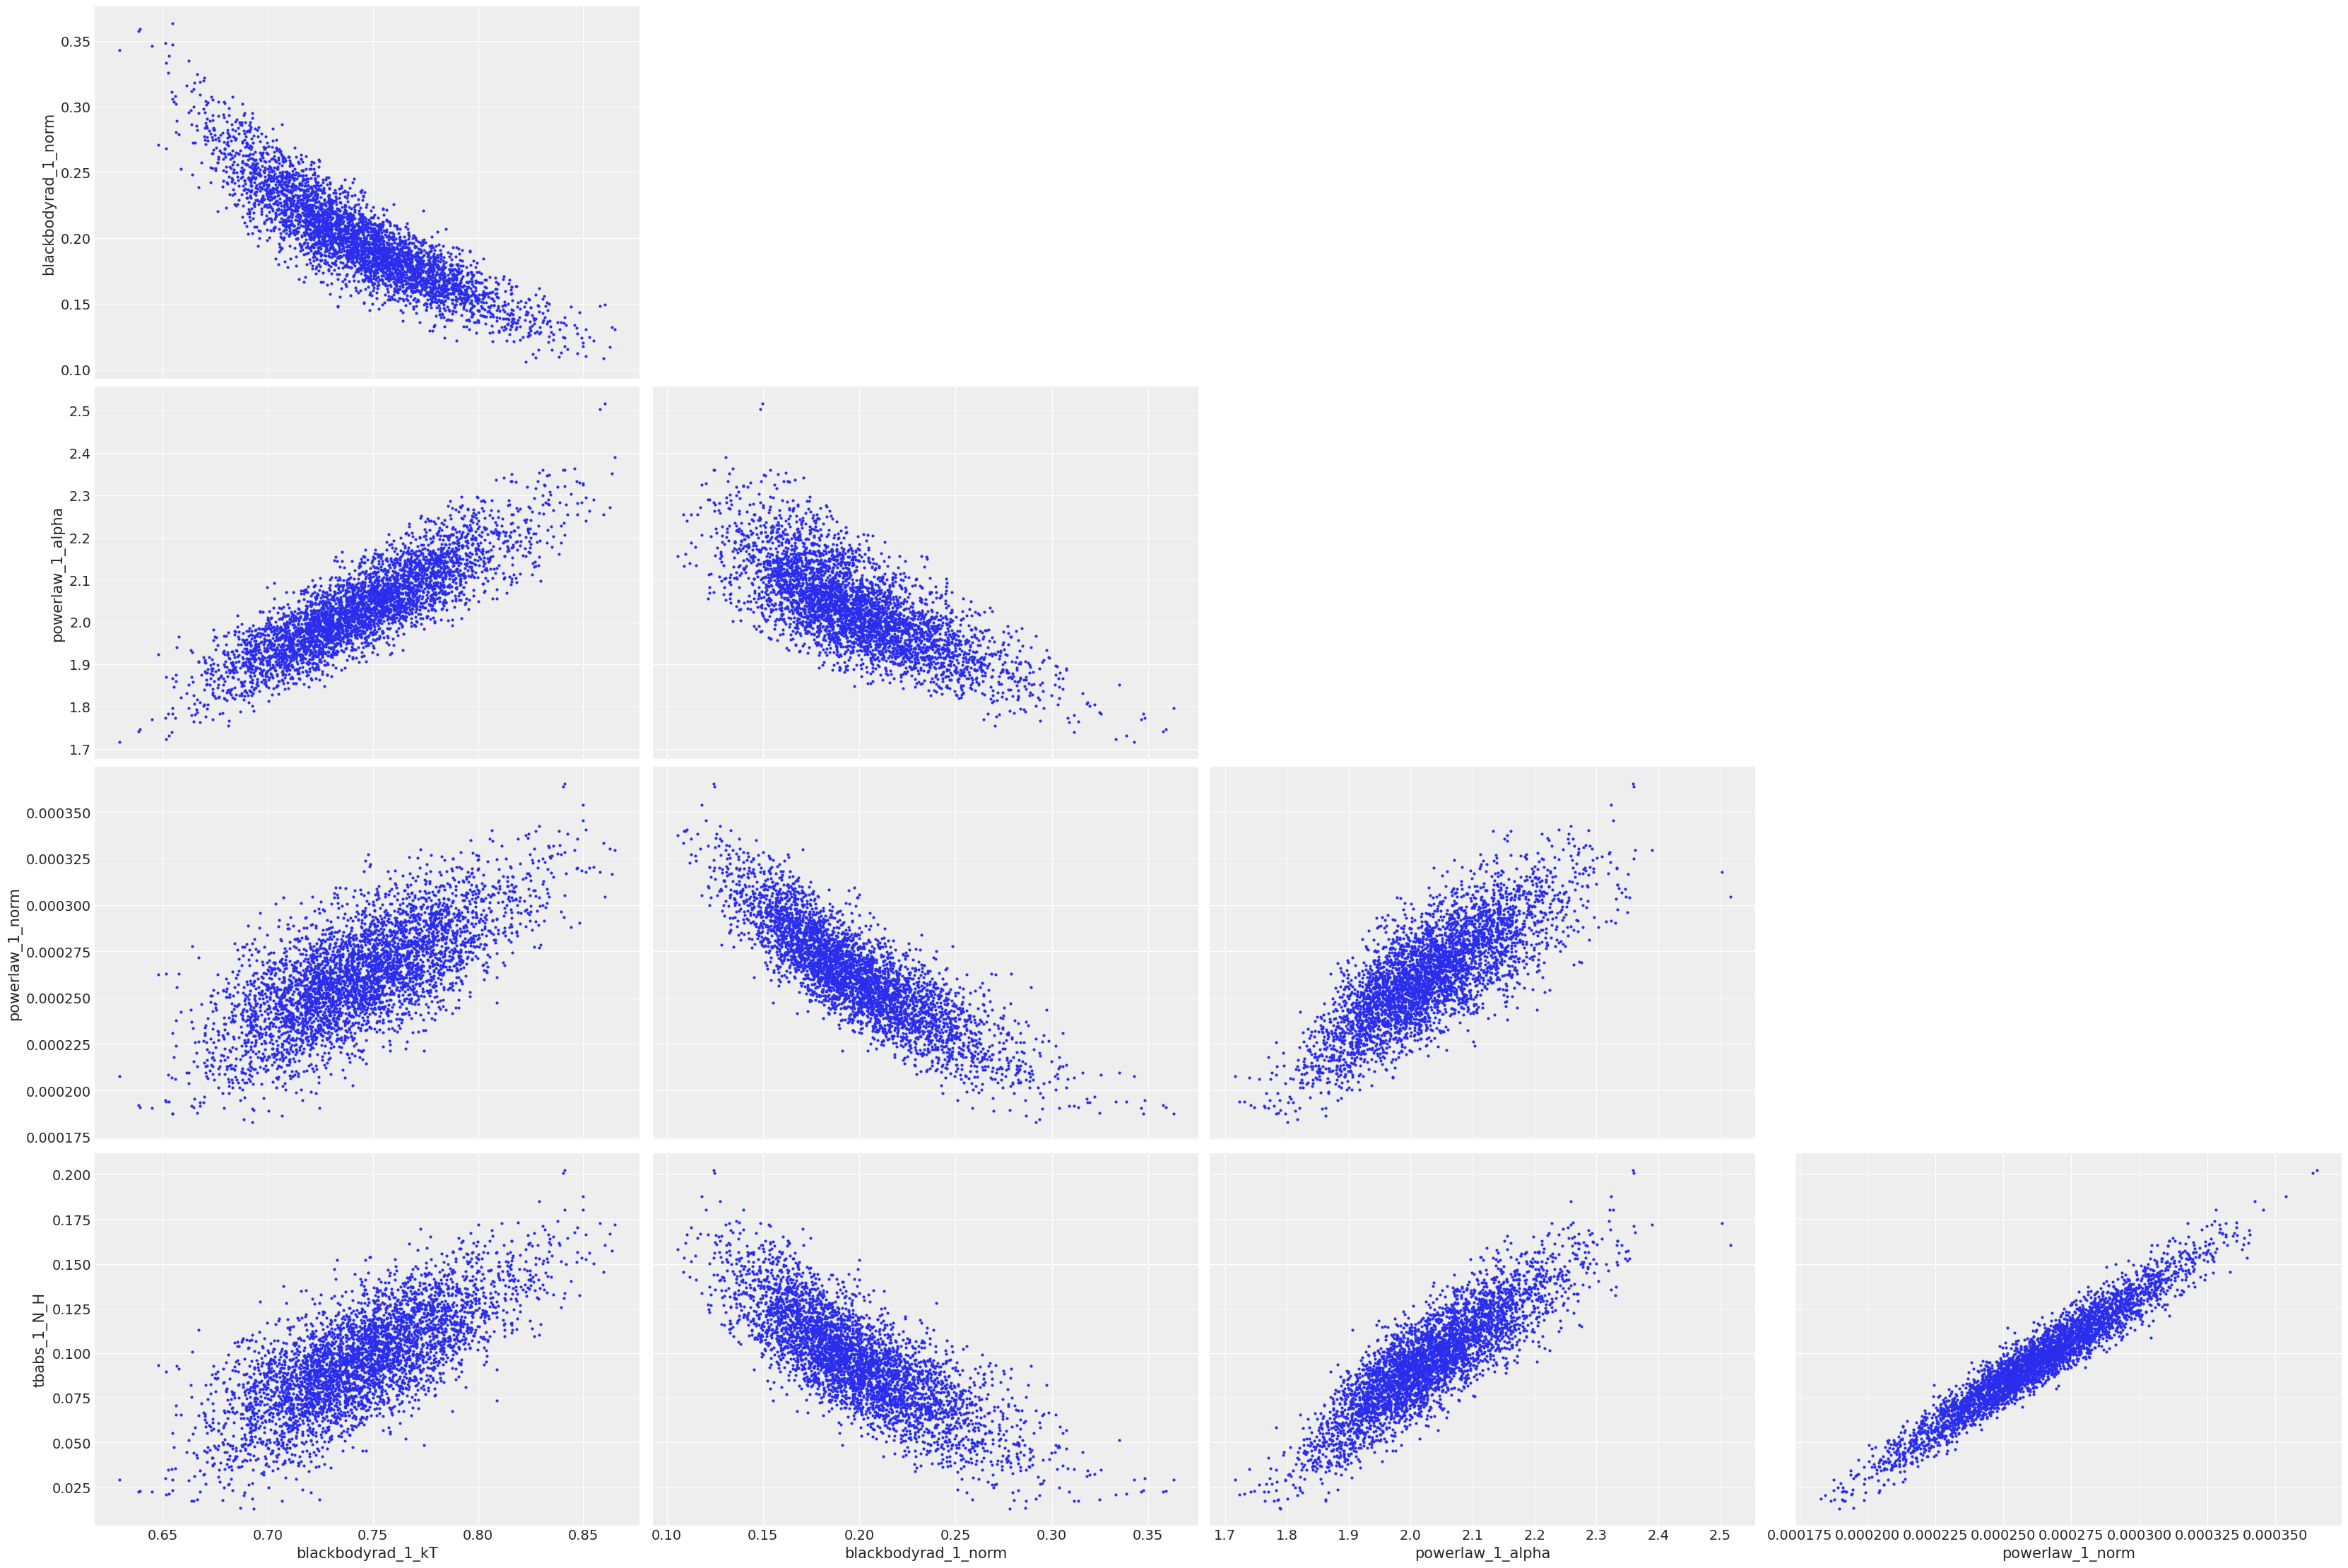

In [9]:
with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_pair(result_nuts.inference_data)
    
plt.show()

Take a look at [`arviz`'s documentation](https://python.arviz.org/en/stable/examples/index.html) to see what else you can do with this library.